# Run linear discriminany analysis on data looking at different directions

In [ ]:
#%matplotlib inline
import sys
import os


import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd
import networkx as nx
#optional for nicer plots
import seaborn
clrs = seaborn.color_palette(n_colors=6)
seaborn.set(style='ticks',font_scale=1.5)

# UPDATE THE PATH BELOW TO THE CODE FOLDER

In [2]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.task import plot_activity_on_graph

# Load stuff

In [4]:
#These are the times (in units of the behaviour system bin running @1000Hz) at which spikes occurred

selected_session = 0

all_data_dir = '/Users/yves/Desktop/retreat_data_dir/data/'
all_data_folders = sorted([i for i in os.listdir(all_data_dir) if 'ks25' in i])
root_dir = os.path.join(all_data_dir,all_data_folders[selected_session])
spkT = np.load(os.path.join(root_dir,'spkT_task.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_task.npy'))

#This is basically a big table (you can open it in excel) which contains
#relevant information about each time the animal poked one of the ports
task_event_df = pd.read_csv(os.path.join(root_dir,'task_event_table.csv'),index_col=0)

#
response_table = np.load(os.path.join(root_dir,'neuron_response_table.npy'))
#alternatively to change the time window


#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

In [5]:
#np.unique(task_event_df['graph_type'])

In [6]:
seq0 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==0]['current_sequence'].values[0]))
seq1 = np.array(eval(task_event_df.loc[task_event_df['task_nr']==1]['current_sequence'].values[0]))

In [7]:
graph_type0 = task_event_df.loc[task_event_df['task_nr']==0]['graph_type'].values[0]
graph_type1 = task_event_df.loc[task_event_df['task_nr']==1]['graph_type'].values[0]
print(graph_type0,graph_type1)

loop loop


In [8]:
def get_task_responses(task_event_df,response_table):
    """ 
    Use the columns of the task_event_df to filter neural activity. 
    In this example build separate firing rate maps for each of the
    tasks, selecting only trials where subjects poked the correct poke.
    
    
    """
    
    
    n_neurons = response_table.shape[1]
    n_ports = 9
    n_tasks = 2
    n_direction = 2
    
    #set variables to nan to not confuse missing data for no responses
    firing_rate_maps = np.zeros([n_neurons,n_ports,n_tasks,n_direction]) + np.nan
    
    #for each task
    for task in [0,1]:
        
        for port in range(n_ports):  #for each port
            
            for dix,direction in enumerate(np.unique(task_event_df['direction'].values)):

                #Select indices of pokes where...
                table_index = task_event_df.loc[(task_event_df['task_nr']==task) &  #task_nr was task
                                                (task_event_df['correct']==True) &  #the poke was to the correct port
                                                (task_event_df['port']==port) &       #the port poked was port
                                                (task_event_df['direction']==direction)
                                               ].index           
                #print(len(table_index))
                #get the average
                firing_rate_maps[:,int(port),int(task),dix] = np.nanmean(response_table[table_index],axis=0)
    return firing_rate_maps
                                         

In [9]:
firing_rate_maps = get_task_responses(task_event_df,response_table)

In [10]:
n_neurons, n_ports, n_tasks, n_directions = firing_rate_maps.shape

In [11]:
spatial_map  = np.nanmean(firing_rate_maps,axis=(2,3))

In [12]:
mds_frm = firing_rate_maps - spatial_map[:,:,None,None]

In [13]:
#mds_frm3 = mds_frm2.copy()

In [14]:
mds_frm2.shape

NameError: name 'mds_frm2' is not defined

In [15]:
#mds_frm = np.concatenate([mds_frm3,mds_frm2],axis=0)

In [16]:
mds_frm.shape

(135, 9, 2, 2)

In [17]:
#mds_frm = mds

In [18]:
from sklearn.manifold import MDS

In [39]:
mds = MDS(n_components=3)

In [40]:
np.unique(task_event_df['graph_type'])

array(['loop'], dtype=object)

In [41]:
mds_frm_flat = np.hstack([mds_frm[:,seq1,0,0],mds_frm[:,seq1,0,1]])#,mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [42]:
mds_frm_flat2 = np.hstack([mds_frm[:,seq1,1,0],mds_frm[:,seq1,1,1]])

In [43]:
out2 = mds.fit_transform(mds_frm_flat.T)

In [44]:
out = mds.fit_transform(mds_frm_flat.T)

In [138]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

In [139]:
U,S,Vt = np.linalg.svd(mds_frm_flat)

In [140]:
Vt.shape

(18, 18)

In [166]:
dat1.shape

(18, 18)

In [163]:
dat1 = Vt
lda = LinearDiscriminantAnalysis()
lda.fit(dat1,np.concatenate([np.ones(9),np.zeros(9)]))
factored_dim = lda.coef_.T.dot(np.dot(lda.coef_,dat1)/np.linalg.norm(lda.coef_)**2)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [164]:
lda2 = LinearDiscriminantAnalysis()
dat2 = (dat1-factored_dim)
lda2.fit(dat2,np.concatenate([np.ones(9),np.zeros(9)]))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

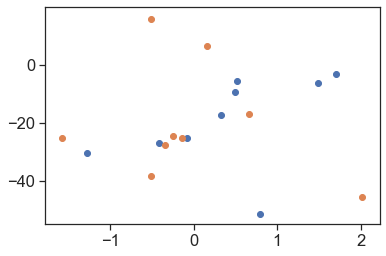

In [156]:
d1 = lda.transform(dat1.T)
d2 = lda2.transform(dat2.T)
plt.scatter(d1[:9],d2[:9])
plt.scatter(d1[9:],d2[9:])

In [97]:
factored_dim.shape

(135, 18)

In [93]:
lda.transform((mds_frm_flat-factored_dim).T)

array([[ -48.72709952],
       [ -58.95053605],
       [ -62.00812523],
       [ -59.43766633],
       [   6.97718292],
       [ -27.33836787],
       [-100.33991157],
       [ -40.73728958],
       [   9.69089571],
       [  18.26747285],
       [-124.57030696],
       [ 108.49318938],
       [  23.96750749],
       [  78.28592694],
       [  69.94303008],
       [  98.12166932],
       [  58.96882629],
       [   8.51127757]])

In [75]:
lda.score(mds_frm_flat2.T,np.concatenate([np.ones(9),np.zeros(9)]))

0.6111111111111112

In [58]:
lda.coef_.shape

(1, 135)

In [49]:
mds_frm_flat.shape

(135, 18)

In [50]:
#%matplotlib auto
%matplotlib inline

In [51]:
from sklearn.svm import SVC


In [52]:
graph_type0

'loop'

In [53]:
graph_type1

'loop'

In [54]:
out.shape

(18, 3)

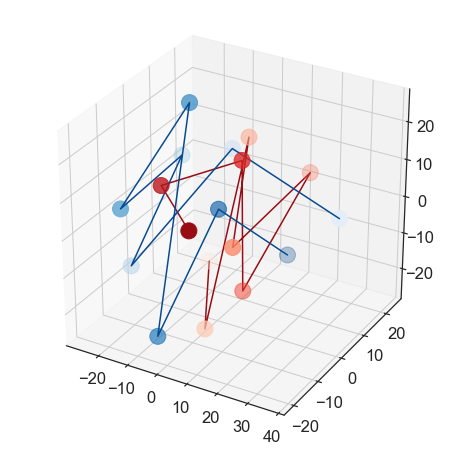

In [56]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for i, task_nr,dirct in [[0,'o',seaborn.color_palette('Reds_r',n_colors=9)],
                          [1,'o',seaborn.color_palette('Blues_r',n_colors=9)]]:
                      # [2,'o',clrs[1]],
                      # [3,'x',clrs[1]]]:
    ax.scatter(out[9*i:(i+1)*9,0],
               out[9*i:(i+1)*9,1],
               out[9*i:(i+1)*9,2],c=dirct, marker=task_nr,s=256)
    
    
    ax.plot(out[9*i:(i+1)*9,0],
               out[9*i:(i+1)*9,1],
               out[9*i:(i+1)*9,2],c=dirct[0])

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')

plt.show()


In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(projection='3d')

for i, task_nr,dirct in [[0,'o',seaborn.color_palette('Reds_r',n_colors=9)],
                          [1,'o',seaborn.color_palette('Blues_r',n_colors=9)]]:
    
    
    for kk in range(6):
        plt.subplot(3,2,plt)
        plt.scatter(out[9*i:(i+1)*9,0],
                    out[9*i:(i+1)*9,0],
                    c=dirct, marker=task_nr,s=256)

    #ax.scatter(out[9*i:(i+1)*9,0],
    #           out[9*i:(i+1)*9,1],
    #           out[9*i:(i+1)*9,2],c=dirct, marker=task_nr,s=256)
    #ax.plot(out[9*i:(i+1)*9,0],
    #           out[9*i:(i+1)*9,1],
    #           out[9*i:(i+1)*9,2],c=dirct[0])

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')

plt.show()


In [63]:
out.shape

(36, 3)

In [ ]:


#
ccs_across = []
for r1,r2 in zip(firing_rate_maps[:,:,0],firing_rate_maps[:,:,1]):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

[1, 3, 6, 0, 2, 8, 4, 7, 5]

In [37]:
task_event_df[210:230]

,target,port,state,task_nr,direction,probe,correct,previous_port,previous_state,reward,block_nr,task_repeat_nr,port_repeat,next_correct,frac_corr,RT,time,current_sequence,graph_type
210,2,2,4,1,-1,False,True,NaN,NaN,True,0,0,True,True,NaN,NaN,204957,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
211,0,0,3,1,-1,False,True,NaN,NaN,True,0,0,False,False,NaN,284.0,205241,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
212,6,4,6,1,-1,False,False,NaN,NaN,False,0,0,False,False,NaN,165.0,205406,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
213,0,4,6,1,-1,False,False,NaN,NaN,True,0,0,True,True,NaN,NaN,206647,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
214,0,0,3,1,-1,False,True,NaN,NaN,True,0,0,True,False,NaN,NaN,206978,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
215,6,4,6,1,-1,False,False,NaN,NaN,True,0,0,False,False,NaN,31.0,207009,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
216,0,1,0,1,-1,False,False,NaN,NaN,True,0,0,True,True,NaN,NaN,207362,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
217,0,0,3,1,-1,False,True,NaN,NaN,True,0,0,True,True,NaN,NaN,207863,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
218,6,6,2,1,-1,False,True,NaN,NaN,True,0,0,False,True,NaN,725.0,208588,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop
219,3,3,1,1,-1,False,True,NaN,NaN,False,0,0,False,False,NaN,1230.0,209818,"[1, 3, 6, 0, 2, 8, 4, 7, 5]",loop


In [246]:
eval(task_event_df.loc[task_event_df['task_nr']==0].iloc[0]['current_sequence'])

[8, 4, 2, 5, 7, 0, 6, 1, 3]

In [247]:
#this is the map from the 
task_sequence_0 = eval(task_event_df.loc[task_event_df['task_nr']==0].iloc[0]['current_sequence'])
task_sequence_1 = eval(task_event_df.loc[task_event_df['task_nr']==1].iloc[0]['current_sequence'])

graph_type_0 = task_event_df.loc[task_event_df['task_nr']==0].iloc[0]['graph_type']
graph_type_1 = task_event_df.loc[task_event_df['task_nr']==1].iloc[0]['graph_type']

In [248]:
firing_rate_maps.shape

(209, 9, 2)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


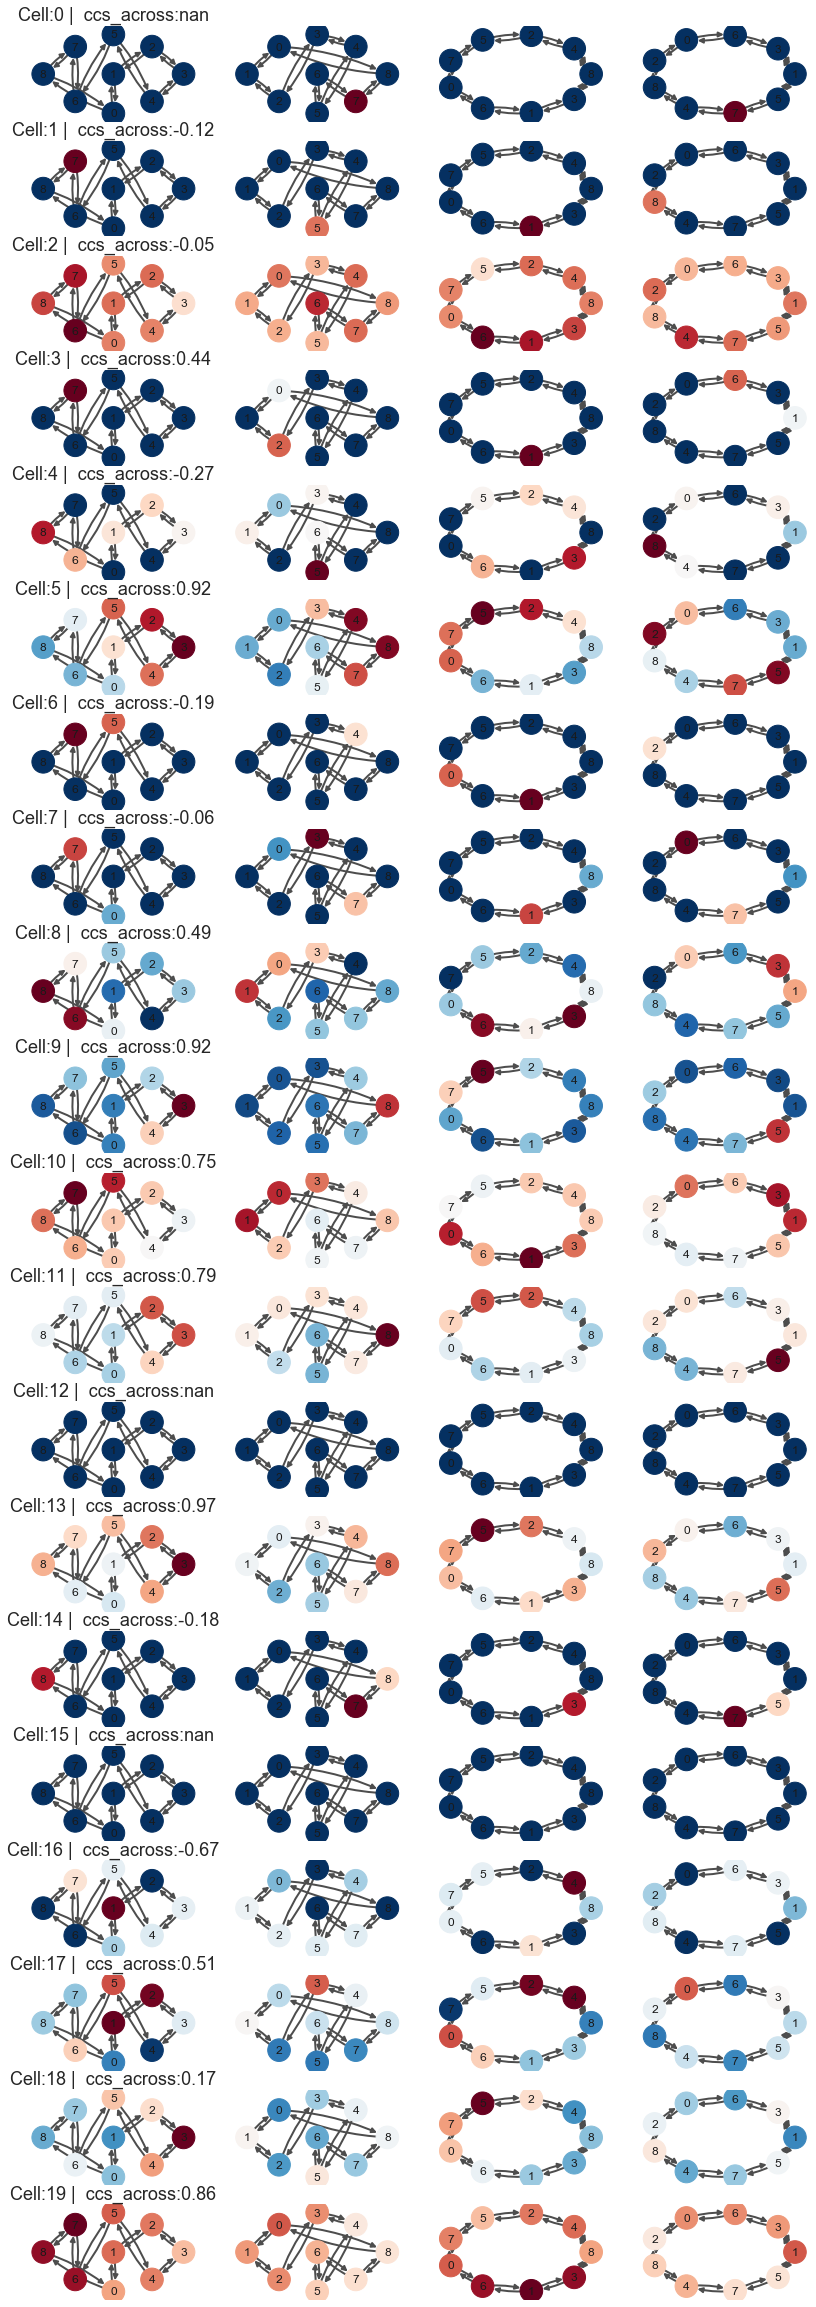

In [249]:
resps_state_g1 = firing_rate_maps[:,:,0][:,task_sequence_0]
resps_state_g2 = firing_rate_maps[:,:,1][:,task_sequence_1]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
n_units = firing_rate_maps.shape[0]
for i in range(20):

    spks1 = firing_rate_maps[:,:,0][i]
    spks2 = firing_rate_maps[:,:,1][i]
    mx = np.nanmax(np.concatenate([spks1,spks2]))
    mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
    plt.subplot(n_plot,4,4*ctr+1)
    plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

    spks = spks1
    plot_activity_on_graph(task_sequence_0,graph_type_0,
                           spks=spks,order='poke',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+2)
    spks = spks2
    plot_activity_on_graph(task_sequence_1,graph_type_1,
                           spks=spks,order='poke',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[i]
    plot_activity_on_graph(task_sequence_0,graph_type_0,
                           spks=spks,order='state',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[i]
    plot_activity_on_graph(task_sequence_1,graph_type_1,
                           spks=spks,order='state',mx=mx,mn=mn)

    ctr +=1

In [250]:
n_neurons, n_ports, n_tasks = firing_rate_maps.shape

In [251]:
from sklearn.decomposition import PCA

In [252]:
U,S,Vt = np.linalg.svd(np.hstack([firing_rate_maps[:,:,0],firing_rate_maps[:,:,1]]))
V = Vt.T

In [259]:
firing_rate_maps.shape

(209, 9, 2)

In [254]:
out = pca.fit_transform(np.hstack([firing_rate_maps[:,:,0],firing_rate_maps[:,:,1]]).T)

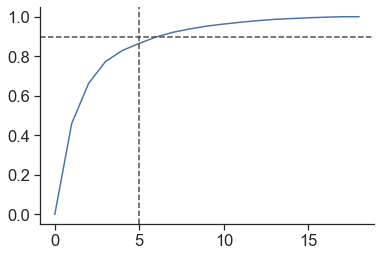

In [255]:
plt.plot(np.concatenate([[0],np.cumsum(pca.explained_variance_ratio_)]))
plt.axhline(y=.9,color='.3',linestyle='--')
plt.axvline(x=5,color='.3',linestyle='--')
seaborn.despine()

In [256]:
np.unique(task_event_df['current_sequence'])

array(['[1, 3, 6, 0, 2, 8, 4, 7, 5]', '[8, 4, 2, 5, 7, 0, 6, 1, 3]'],
      dtype=object)

In [257]:
np.max(resps_state_g1[5])

5.735294117647059

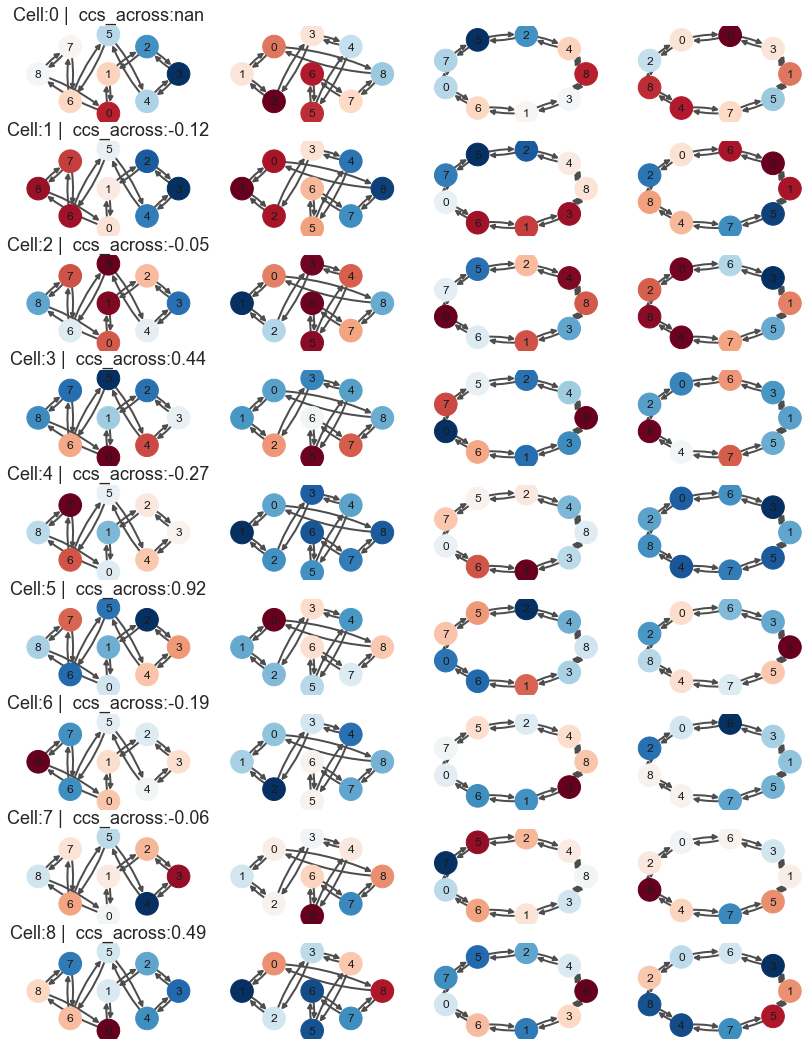

In [231]:
resps_state_g1 = V[:9][task_sequence_0]#out[:9][:,task_sequence_0]
resps_state_g2 = V[9:][task_sequence_1]#out[9:][:,task_sequence_1]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
n_units = firing_rate_maps.shape[0]
for i in range(9):

    spks1 = V[:9][:,i]#firing_rate_maps[:,:,0][i]
    spks2 = V[9:][:,i]
    mx = np.nanmax(np.concatenate([spks1,spks2]))
    mn = np.nanmin(np.concatenate([spks1,spks2]))
    plt.subplot(n_plot,4,4*ctr+1)
    plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

    spks = spks1
    plot_activity_on_graph(task_sequence_0,graph_type_0,
                           spks=spks,order='poke',mx=mx,mn=mn)
    
    #print(np.max(spks),np.min(spks))
    plt.subplot(n_plot,4,4*ctr+2)
    spks = spks2
    plot_activity_on_graph(task_sequence_1,graph_type_1,
                           spks=spks,order='poke',mx=mx,mn=mn)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[:,i]
    plot_activity_on_graph(task_sequence_0,graph_type_0,
                           spks=spks,order='state',mx=mx,mn=mn)
    #print(np.max(spks),np.min(spks))
    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[:,i]
    plot_activity_on_graph(task_sequence_1,graph_type_1,
                           spks=spks,order='state',mx=mx,mn=mn)

    ctr +=1

In [258]:
from sklearn.manifold import MDS

In [260]:
resps_state_g1 = firing_rate_maps[:,:,0][:,task_sequence_0]
resps_state_g2 = firing_rate_maps[:,:,1][:,task_sequence_1]


mean_resps_state = np.nanmean(firing_rate_maps,axis=2)
resps_state_task1 = (firing_rate_maps[:,:,0]-mean_resps_state)[:,task_sequence_0]
resps_state_task2 = (firing_rate_maps[:,:,1]-mean_resps_state)[:,task_sequence_1]


